In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import optuna 
import math
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor


In [2]:
adidas_final_df = pd.read_csv('adidas_final_df.csv')
text_df_256 = pd.read_csv('text_df_256.csv')
img_inceptionv3_256_df = pd.read_csv('img_inceptionv3_256_df.csv')


text_df_256 = text_df_256.iloc[:, 1:]
text_df_256.columns = list('text' + str(i) for i in range(len(text_df_256.columns)))

img_inceptionv3_256_df = img_inceptionv3_256_df.iloc[:, 1:]
img_inceptionv3_256_df.columns = list('img' + str(i) for i in range(len(img_inceptionv3_256_df.columns)))


df = pd.concat([adidas_final_df[['retail_price', 'avg_sale_price_12_month']], img_inceptionv3_256_df, text_df_256], axis=1)


X = df.drop('avg_sale_price_12_month', axis=1)
y = df['avg_sale_price_12_month']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=20)

In [10]:
lin_reg = LinearRegression()

# 訓練用と検証用の結果を納める
train_errors, val_errors = [], []

# 10個目のデータから順に、10、110と100個飛ばして回す
for m in range(10, len(X_train), 100):

    # 順番に110, 210, 310, ...、と訓練し、検証セットとの汎化誤差を比べる
    lin_reg.fit(X_train[:m], y_train[:m])
    y_train_predict = lin_reg.predict(X_train[:m])
    y_val_predict = lin_reg.predict(X_val)
    train_mse = mean_squared_error(y_train[:m], y_train_predict)
    val_mse = mean_squared_error(y_val, y_val_predict)
    train_rmse = np.sqrt(train_mse)
    val_rmse = np.sqrt(val_mse)

    # それぞれのRMSEをリストに収める
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)

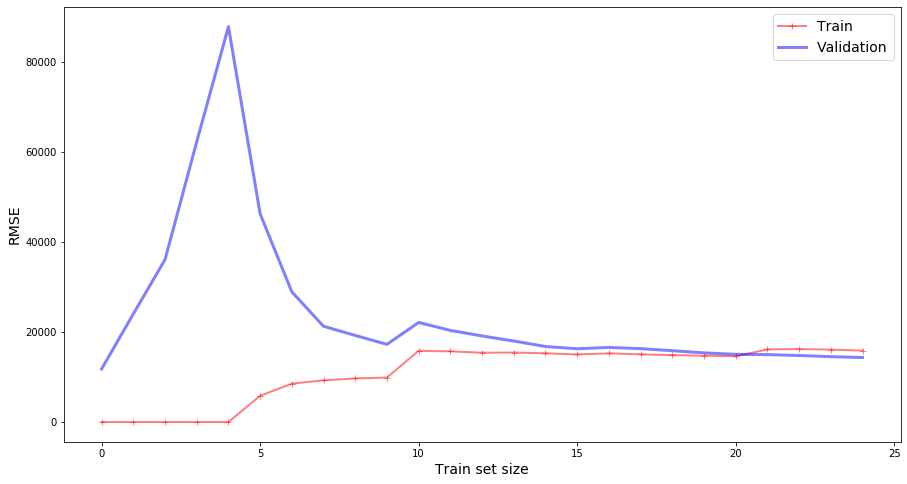

In [11]:
# 実行

 # 画像サイズ
plt.figure(figsize=(15, 8))
 # 訓練セット
plt.plot(train_errors, "r-+", alpha=0.5, linewidth=2, label="Train")
 # 検証セット
plt.plot(val_errors, "b-", alpha=0.5, linewidth=3, label="Validation")
 # 凡例
plt.legend(loc="upper right", fontsize=14)
 # x軸の名前
plt.xlabel("Train set size", fontsize=14)
 # y軸の名前
plt.ylabel("RMSE", fontsize=14)
 # x軸のメモリは0からtrain_errorsサイズを指定
 # y軸のメモリは0から0.7に指定（この範囲にだいたい分布がされるので）
# plt.axis([0, len(train_errors), 0, 0.7])
plt.savefig('Linear_error.png')
plt.show()

In [22]:
# データフレーム用の空リスト
# 訓練誤差と検証誤差の誤差を格納
generalization_error = []

# model_nameにモデル名を入れる
def plot_learning_curves(model, X, y, model_name=None):

    # japanize_matplotlibで日本語設定
#     import japanize_matplotlib
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []

    # 10個目のデータから順に、110、210と310個飛ばして回す
    for m in range(10, len(X_train), 100):

        # 順番に10, 110, 210, ...、と訓練し、検証誤差を出す
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_mse = mean_squared_error(y_train[:m], y_train_predict)
        val_mse = mean_squared_error(y_val, y_val_predict)
        train_rmse = np.sqrt(train_mse)
        val_rmse = np.sqrt(val_mse)

        # それぞれのRMSEをリストに収める
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)

    # それぞれの一番最終のRMSEの誤差を出す
    train_val_error = np.round(train_errors[-1] - val_errors[-1], 4)

    # 訓練誤差と検証誤差の誤差を絶対値に置き換える
    train_val_error = np.abs(train_val_error)

    # データフレーム用の空リストに収める
    generalization_error.append(train_val_error)
    plt.figure(figsize=(15, 8))
    plt.plot(train_errors, "r-+", alpha=0.5, linewidth=2, label="train")
    plt.plot(val_errors, "b-", alpha=0.5, linewidth=3, label="valid")
    plt.legend(loc="upper right", fontsize=14)
    plt.xlabel("number of training sets", fontsize=14)
    plt.ylabel("RMSE", fontsize=14)

    # 最終のRMSEと、訓練・検証の差をタイトルに表示。
    plt.title('{0}のtrain_rmse:{1}、valid_rmse:{2}、gap is{3}'.format(model_name, 
                                                                    np.round(train_errors[-1], 4),
                                                                    np.round(val_errors[-1], 4),
                                                                    train_val_error), fontsize=18)

#     plt.axis([0, len(train_errors), 0, 0.7])
#     plt.savefig('{}_error.png'.format(model_name))
    plt.show()


C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12289 missing from current font.
  font.set_text(s, 0, flags=flags)


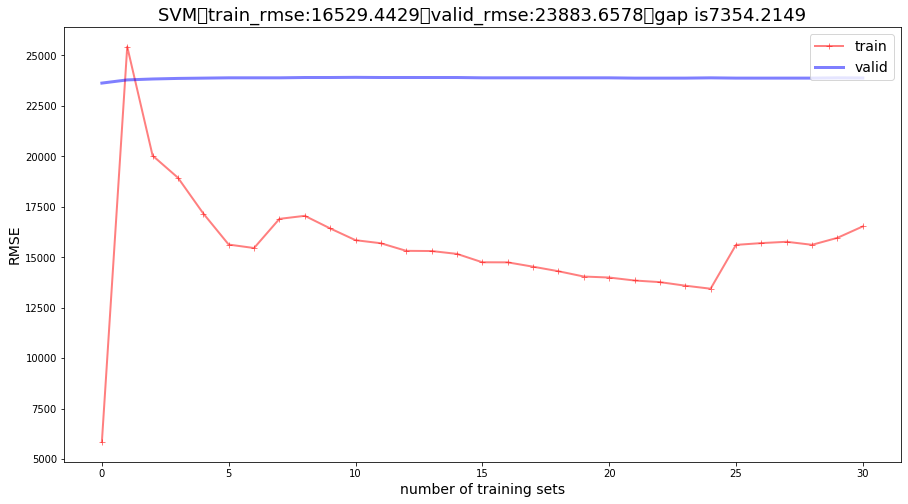

In [23]:
# 実行
from sklearn.svm import SVR

svm_reg = SVR(gamma='auto')

plot_learning_curves(svm_reg, X, y, model_name='SVM')

C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12289 missing from current font.
  font.set_text(s, 0, flags=flags)


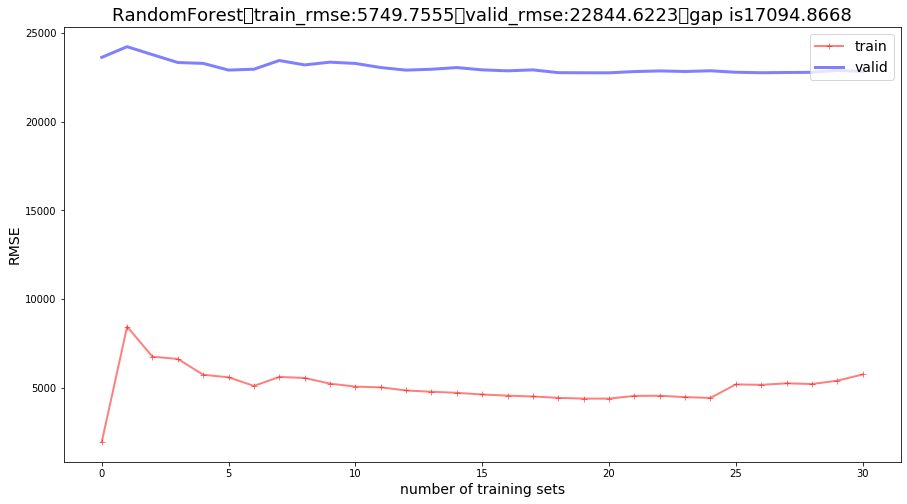

In [24]:
# 実行

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)

plot_learning_curves(forest_reg, X, y, model_name='RandomForest')

C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12289 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 12289 missing from current font.
  font.set_text(s, 0, flags=flags)


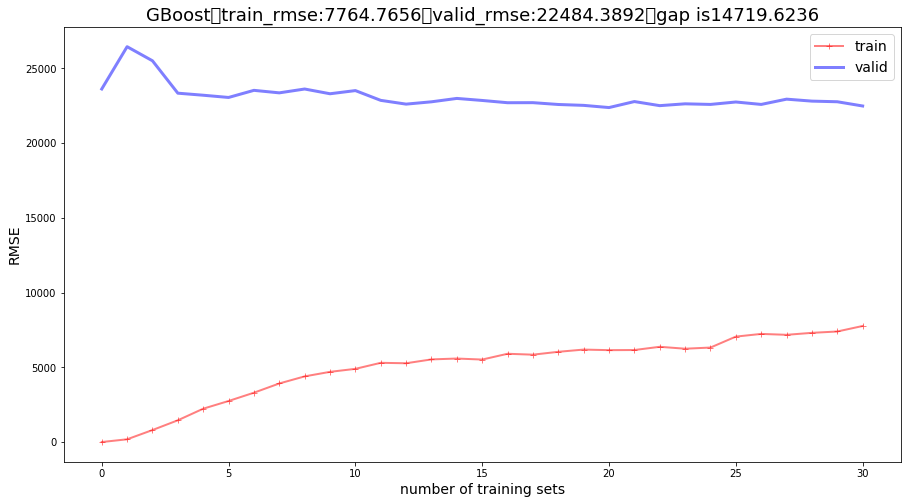

In [26]:
# 実行

from sklearn.ensemble import GradientBoostingRegressor

gb_reg = GradientBoostingRegressor(random_state=42)

plot_learning_curves(gb_reg, X, y, model_name='GBoost')

C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\Kei\anaconda3\envs\py_env\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Kei\anacond

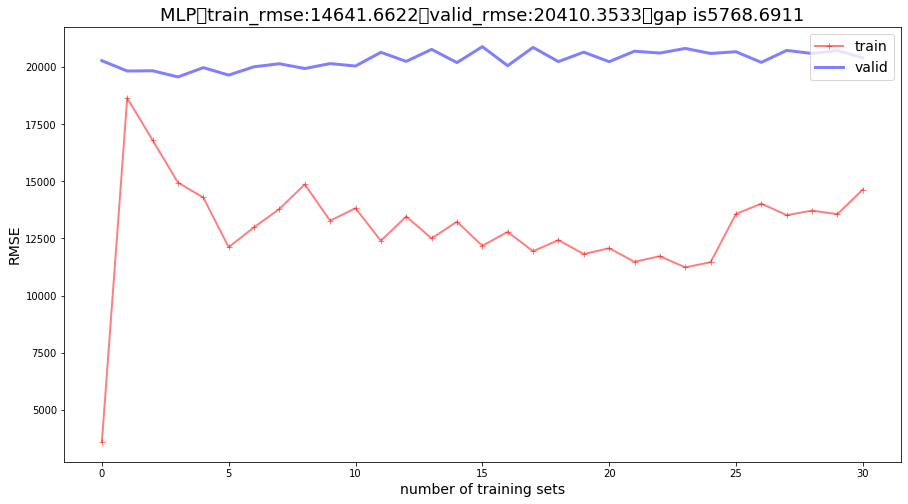

In [28]:
# 実行

from sklearn.neural_network import MLPRegressor

mlp_reg = MLPRegressor(max_iter=1500, random_state=42)

plot_learning_curves(mlp_reg, X, y, model_name='MLP')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

 # kernel：　ガウスRBFカーネル・線形カーネル・多項式カーネル
 # C：　正則化ハイパーパラメータ、小さくすると制御を強める
 # degree：　多項式回帰の次元設定
param_random = {
    'kernel': ['rbf', 'linear', 'poly'],
    'C': [0.001, 0.01, 1],
    'degree': [2],
    'gamma': ['auto'],
}

svm_reg = SVR()

svm_random_search = RandomizedSearchCV(svm_reg,
                                       param_random,
                                       cv=5,
                                       scoring='neg_mean_squared_error',
                                       n_iter=9,
                                       random_state=42)

svm_random_search.fit(X, y)

svm_random_search.best_params_

In [ ]:
# 実行

generalization_error = []

plot_learning_curves(svm_random_search.best_estimator_, X, y, model_name='best_SVM')

In [ ]:
# max_depth: 最大ノード数（正則化の制御、多項式回帰のdegreeのようなもの）
# n_estimators: 決定木の個数
random_search = {'max_depth': [1, 2],
                 'n_estimators': [300, 500, 1000, 2000],
                 'random_state': [42]}

forest_reg = RandomForestRegressor()

forest_random_search = RandomizedSearchCV(forest_reg,
                                          random_search,
                                          cv=5,
                                          n_jobs=-1,
                                          scoring='neg_mean_squared_error',
                                          n_iter=8,
                                          random_state=42)

forest_random_search.fit(X, y)

forest_random_search.best_params_

In [ ]:
# 実行

plot_learning_curves(forest_random_search.best_estimator_, X, y, model_name='best_RandomForest')

In [ ]:
 # max_depth: 最大ノード数（正則化）
 # n_estimators: 決定木の個数
random_search = {'max_depth': [1, 2],
                 'n_estimators': [300, 500, 1000, 2000],
                 'random_state': [42]}

gb_reg = GradientBoostingRegressor()

gb_random_search = RandomizedSearchCV(gb_reg,
                                      random_search,
                                      cv=5,
                                      n_jobs=-1,
                                      scoring='neg_mean_squared_error',
                                      n_iter=8,
                                      random_state=42)

gb_random_search.fit(X, y)

gb_random_search.best_params_

In [ ]:
# 実行

plot_learning_curves(gb_random_search.best_estimator_, X, y, model_name='best_GBoost')

In [ ]:
 # hidden_layer_sizes: ニューロンと層の数
 # learning_rate_init: 重みを更新するステップサイズの制御
 # max_iter: エポック数
 # epsilon: ReLuの正則化ハイパーパラメータ値
random_search = {'hidden_layer_sizes': [(100),
                                        (100, 100),
                                        (20, 30, 50, 30, 20),
                                        (20, 50, 80, 50, 20),
                                        (20, 100, 100, 100, 20)],
                 'learning_rate_init': [0.1, 0.01, 0.001, 0.0001],
                 'epsilon': [0.01, 0.1, 0.2, 1],
                 'max_iter': [1500],
                 'random_state': [42]}

mlp_reg = MLPRegressor()

mlp_random_search = RandomizedSearchCV(mlp_reg,
                                       random_search,
                                       cv=5,
                                       n_jobs=-1,
                                       scoring='neg_mean_squared_error',
                                       n_iter=20,
                                       random_state=42)

mlp_random_search.fit(X, y)

mlp_random_search.best_params_

In [ ]:
# 実行

plot_learning_curves(mlp_random_search.best_estimator_, X, y, model_name='best_MLP')

In [ ]:
df_error['Random_Search'] = generalization_error
df_error